In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from transformers import AutoConfig
from transformers import AutoModelForSequenceClassification
import torch
import numpy as np
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print(torch.backends.mps.is_available())

2.7.0
CUDA available: False
True


In [2]:
df = pd.read_csv("subsequences_dataset.csv")
df["label"] = df["label"].astype(float)


train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)
df.head()
test_df.shape


(13096, 6)

In [3]:
tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-50m-multi-species")

def tokenize(batch):
    return tokenizer(batch["sequence"], padding="max_length", truncation=True, max_length=512)


/Users/tristanferdinand/Desktop/Work/Knight Lab Research/Computational Micrbial Data Cleaning/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
from datasets import Dataset
from pprint import pprint

train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

for i in range(3):
    pprint(train_ds[i])
print(train_ds[0]["label"].dtype)  # Should be torch.float32


Map:   0%|          | 0/61114 [00:00<?, ? examples/s]

Map:   0%|          | 0/13096 [00:00<?, ? examples/s]

Map:   0%|          | 0/13096 [00:00<?, ? examples/s]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0

In [5]:
print("Label distribution:")
print(df['label'].value_counts())
print("Label dtype:", df['label'].dtype)

Label distribution:
label
1.0    43653
0.0    43653
Name: count, dtype: int64
Label dtype: float64


In [6]:
config = AutoConfig.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-50m-multi-species")
config.num_labels = 1
config.problem_type = "regression"

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
model = AutoModelForSequenceClassification.from_config(config)
model.to(device)

mps


W0815 13:20:22.872000 86701 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


EsmForSequenceClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(4107, 512, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(2050, 512, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-11): 12 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((512,), eps=1e

In [7]:
N_train = 1000
N_val = 200

train_subset = train_ds.select(range(N_train))
val_subset = val_ds.select(range(N_val))

train_subset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_subset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [8]:
from transformers import TrainerCallback

class LossLoggingCallback(TrainerCallback):
    def on_log(self, args, state, control, **kwargs):
        if 'train_loss' in kwargs.get('logs', {}):
            print(f"Step {state.global_step}: Train Loss = {kwargs['logs']['train_loss']:.4f}")

In [9]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np

def compute_metrics(p):
    # Flatten logits from shape (N, 1) to (N,)
    logits = p.predictions.flatten()

    # Apply sigmoid to get probabilities
    probs = 1 / (1 + np.exp(-logits))

    # Threshold at 0.5 to get binary predictions
    preds = (probs > 0.5).astype(int)

    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    #logging_steps=10,  # Log every 10 steps
    #logging_strategy="steps",  # Add this
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    learning_rate=1e-5,  # Lower learning rate
    warmup_steps=100,    # Add warmup
    lr_scheduler_type="cosine",  # Decay learning rate
    metric_for_best_model="f1",
    greater_is_better=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    callbacks=[LossLoggingCallback()] 
)


/Users/tristanferdinand/Desktop/Work/Knight Lab Research/Computational Micrbial Data Cleaning/.venv/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [10]:
trainer.train()

/Users/tristanferdinand/Desktop/Work/Knight Lab Research/Computational Micrbial Data Cleaning/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.045100,0.037331,0.881414,0.893971
2,0.030000,0.032697,0.510690,0.671452
3,0.022400,0.032300,0.866448,0.882071
4,0.014900,0.033306,0.911271,0.918445
5,0.010900,0.033478,0.755574,0.803366


/Users/tristanferdinand/Desktop/Work/Knight Lab Research/Computational Micrbial Data Cleaning/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/tristanferdinand/Desktop/Work/Knight Lab Research/Computational Micrbial Data Cleaning/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/tristanferdinand/Desktop/Work/Knight Lab Research/Computational Micrbial Data Cleaning/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/tristanferdinand/Desktop/Work/Knight Lab Research/Computa

Step 19100: Train Loss = 0.0280


TrainOutput(global_step=19100, training_loss=0.027991386127721576, metrics={'train_runtime': 36439.0422, 'train_samples_per_second': 8.386, 'train_steps_per_second': 0.524, 'total_flos': 3.575831401445376e+16, 'train_loss': 0.027991386127721576, 'epoch': 5.0})

In [10]:
best_model_path = "./results/checkpoint-15280"
print(best_model_path)

./results/checkpoint-15280


In [11]:
from transformers import AutoConfig

# Load config from checkpoint
checkpoint_config = AutoConfig.from_pretrained(best_model_path)
print('Checkpoint intermediate_size:', getattr(checkpoint_config, 'intermediate_size', 'Not found'))

# Load config from base model
base_config = AutoConfig.from_pretrained('InstaDeepAI/nucleotide-transformer-v2-50m-multi-species')
print('Base model intermediate_size:', getattr(base_config, 'intermediate_size', 'Not found'))

Checkpoint intermediate_size: 2048


/Users/tristanferdinand/Desktop/Work/Knight Lab Research/Computational Micrbial Data Cleaning/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Base model intermediate_size: 2048


In [12]:
config = AutoConfig.from_pretrained(best_model_path)
model = AutoModelForSequenceClassification.from_pretrained(best_model_path)
model.to(device)


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at ./results/checkpoint-15280 and are newly initialized: ['esm.embeddings.position_embeddings.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EsmForSequenceClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(4107, 512, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(2050, 512, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-11): 12 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((512,), eps=1e

In [13]:
torch.mps.empty_cache()

In [14]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tqdm import tqdm

# Ensure your model is in eval mode
def test_model_on_dataset(model, ds):
    model.eval()
    test_loader = torch.utils.data.DataLoader(
        ds, batch_size=32, shuffle=False
    )
    all_preds = []
    all_labels = []
    all_attention_weights = None  # just one batch or summary
    with torch.no_grad():
        for i, batch in enumerate(tqdm(test_loader, desc='Testing')):
            input_ids = batch['input_ids'].to(model.device)
            attention_mask = batch['attention_mask'].to(model.device)
            labels = batch['label'].cpu().numpy()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
            attention_weights = outputs.attentions 
            logits = outputs.logits.squeeze(-1).cpu().numpy()
            preds = (1 / (1 + np.exp(-logits)) > 0.5).astype(int)
            all_preds.extend(preds)
            all_labels.extend(labels)
            
            # Save only last batch's attention weights (or first batch, etc.)
            if i == 0:  # or some other condition
                all_attention_weights = [att.cpu().numpy() for att in attention_weights]
            
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    return acc, f1, all_attention_weights


# Run test on Test Set
torch.mps.empty_cache()
test_acc, test_f1, attention_weights = test_model_on_dataset(model, test_ds)
print("Attention Weights Shape:", attention_weights[0].shape)
print("Test Accuracy:", test_acc)
print("Test F1:", test_f1)


Testing: 100%|██████████| 410/410 [03:57<00:00,  1.73it/s]


Test Accuracy: 0.9129
Test F1 Score: 0.9197
Confusion Matrix:
[[5419 1129]
 [  12 6536]]
Attention Weights Shape: (32, 16, 512, 512)
Test Accuracy: 0.9128741600488699
Test F1: 0.9197213818335327


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def visualize_attention_heatmap(attention_weights, tokenizer, input_ids, layer_idx=-1, head_idx=0, 
                               sample_idx=0, max_tokens=50, figsize=(12, 10)):
    """
    Visualize attention weights as a heatmap
    
    Args:
        attention_weights: List of attention tensors from model output
        tokenizer: The tokenizer used to decode input_ids
        input_ids: The input token ids for the sample
        layer_idx: Which layer to visualize (-1 for last layer)
        head_idx: Which attention head to visualize
        sample_idx: Which sample in the batch to visualize
        max_tokens: Maximum number of tokens to display
        figsize: Figure size tuple
    """
    
    # Get the attention weights for the specified layer and head
    # Shape: (batch_size, num_heads, seq_len, seq_len)
    layer_attention = attention_weights[layer_idx][sample_idx, head_idx]
    
    # Get tokens from input_ids
    tokens = tokenizer.convert_ids_to_tokens(input_ids[sample_idx])
    
    # Limit the number of tokens for better visualization
    if len(tokens) > max_tokens:
        tokens = tokens[:max_tokens]
        layer_attention = layer_attention[:max_tokens, :max_tokens]
    
    # Create the heatmap
    plt.figure(figsize=figsize)
    
    # Create a custom colormap (blue to red)
    colors = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08519c', '#08306b']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('attention', colors, N=n_bins)
    
    # Create heatmap
    sns.heatmap(layer_attention, 
                xticklabels=tokens, 
                yticklabels=tokens,
                cmap=cmap,
                square=True,
                cbar_kws={'label': 'Attention Weight'},
                linewidths=0.1)
    
    plt.title(f'Attention Heatmap - Layer {layer_idx}, Head {head_idx}', fontsize=16, pad=20)
    plt.xlabel('Key Tokens', fontsize=12)
    plt.ylabel('Query Tokens', fontsize=12)
    
    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

def visualize_multiple_heads(attention_weights, tokenizer, input_ids, layer_idx=-1, 
                            num_heads=4, sample_idx=0, max_tokens=30, figsize=(16, 12)):
    """
    Visualize multiple attention heads in a grid
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()
    
    tokens = tokenizer.convert_ids_to_tokens(input_ids[sample_idx])
    if len(tokens) > max_tokens:
        tokens = tokens[:max_tokens]
    
    # Create custom colormap
    colors = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08519c', '#08306b']
    cmap = LinearSegmentedColormap.from_list('attention', colors, N=100)
    
    for head_idx in range(min(num_heads, 4)):  # Max 4 heads for 2x2 grid
        layer_attention = attention_weights[layer_idx][sample_idx, head_idx]
        
        if len(tokens) < layer_attention.shape[0]:
            layer_attention = layer_attention[:len(tokens), :len(tokens)]
        
        sns.heatmap(layer_attention, 
                   xticklabels=tokens if head_idx >= 2 else False,  # Only show x labels for bottom row
                   yticklabels=tokens if head_idx % 2 == 0 else False,  # Only show y labels for left column
                   cmap=cmap,
                   square=True,
                   cbar=True,
                   ax=axes[head_idx],
                   cbar_kws={'label': 'Attention Weight'} if head_idx == 3 else {})
        
        axes[head_idx].set_title(f'Head {head_idx}', fontsize=12)
        
        if head_idx >= 2:  # Bottom row
            axes[head_idx].set_xlabel('Key Tokens')
            plt.setp(axes[head_idx].get_xticklabels(), rotation=45, ha='right')
        
        if head_idx % 2 == 0:  # Left column
            axes[head_idx].set_ylabel('Query Tokens')
    
    plt.suptitle(f'Attention Heads - Layer {layer_idx}', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

def plot_attention_summary(attention_weights, layer_range=None):
    """
    Plot a summary of attention patterns across layers
    """
    num_layers = len(attention_weights)
    if layer_range is None:
        layer_range = range(num_layers)
    
    # Calculate average attention for each layer
    avg_attentions = []
    for layer_idx in layer_range:
        # Average across batch, heads, and positions
        avg_att = np.mean(attention_weights[layer_idx])
        avg_attentions.append(avg_att)
    
    plt.figure(figsize=(10, 6))
    plt.plot(layer_range, avg_attentions, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Layer Index', fontsize=12)
    plt.ylabel('Average Attention Weight', fontsize=12)
    plt.title('Average Attention Weight by Layer', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage with your data:
# First, you'll need to get the input_ids for the sample you want to visualize
# This assumes you have access to the tokenizer and the original input



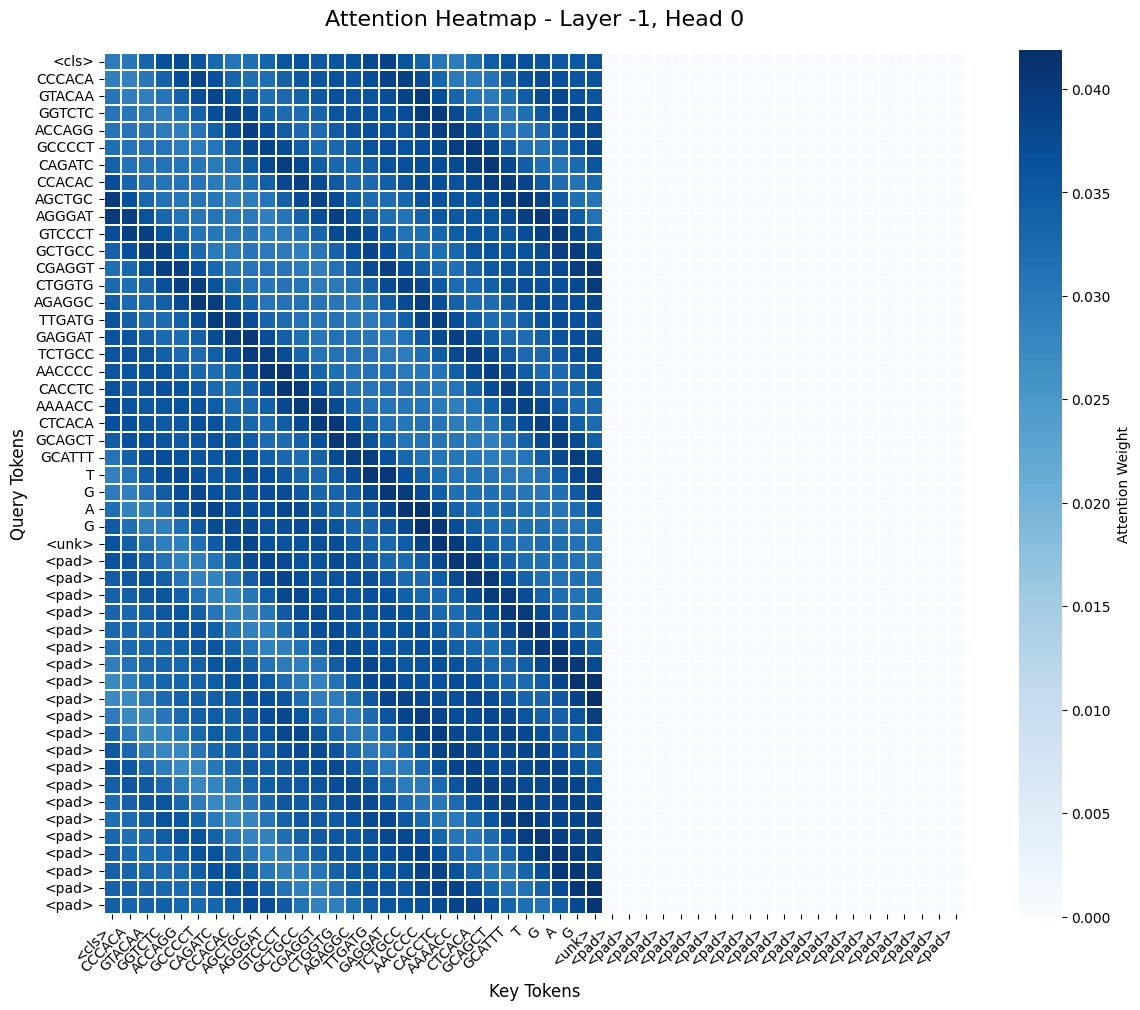

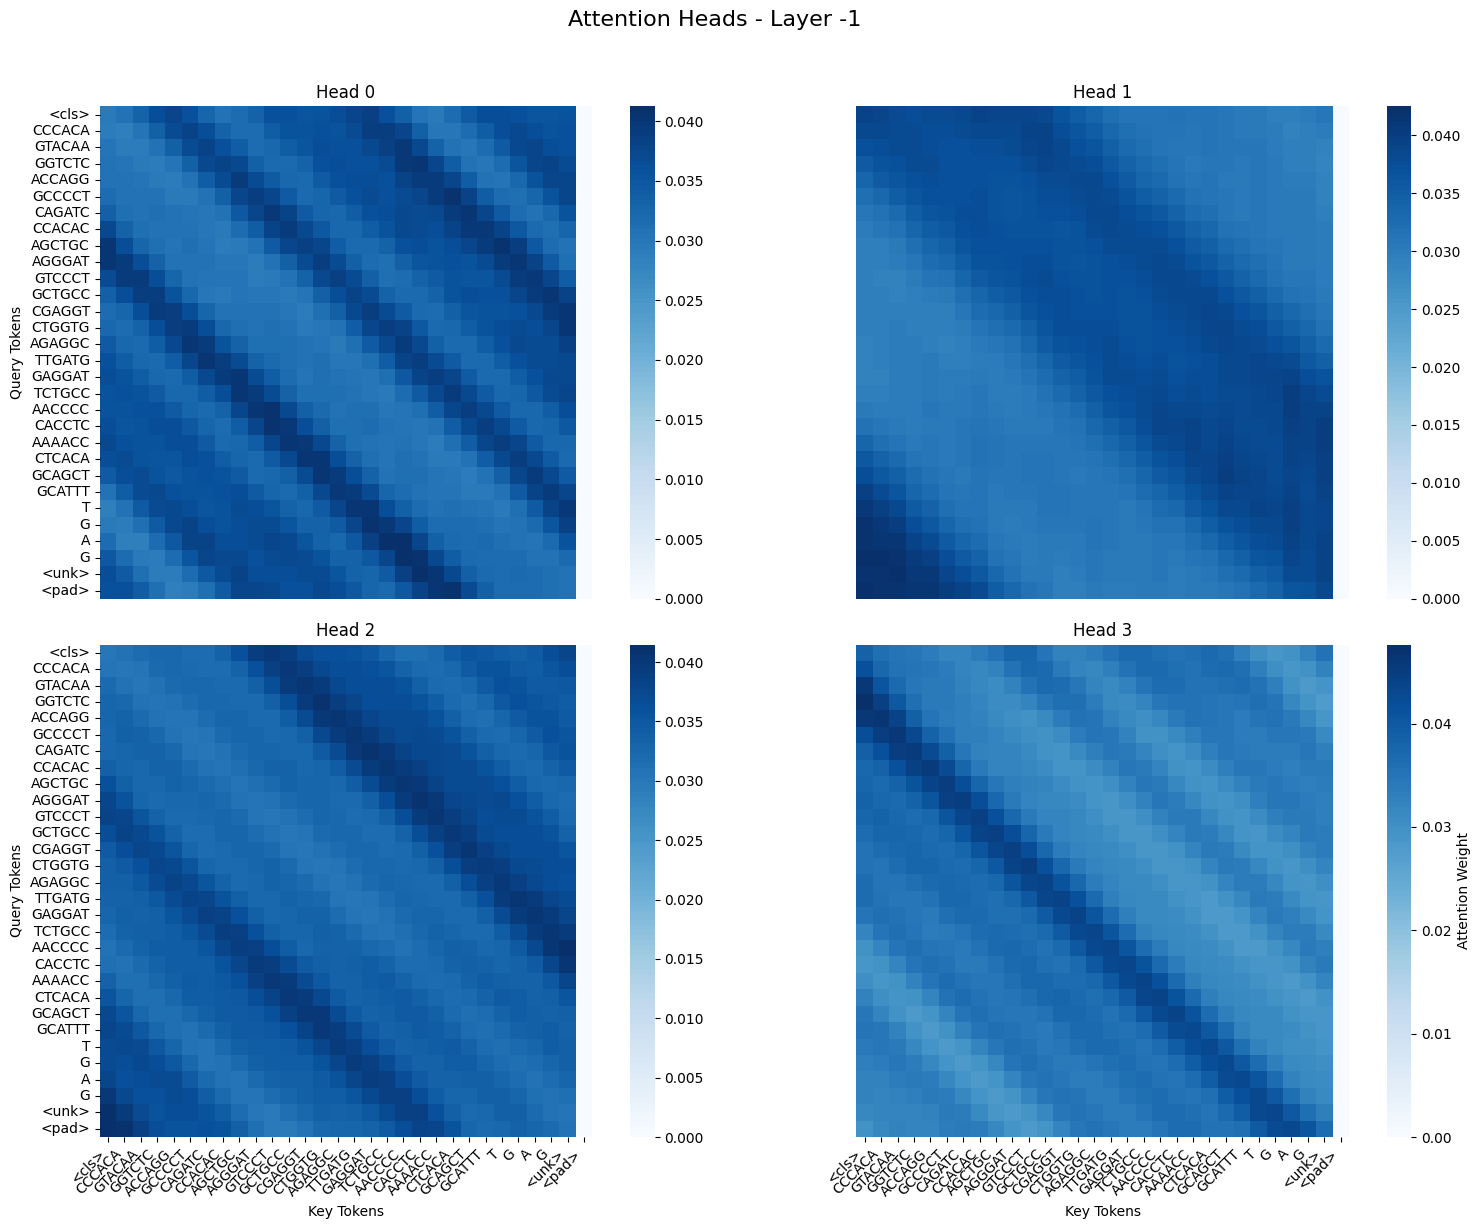

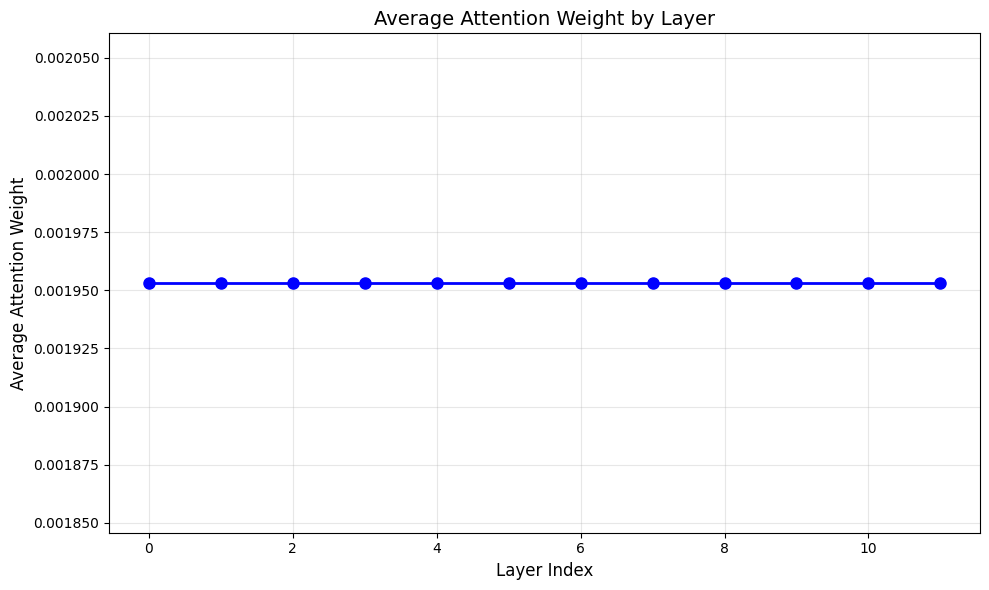

In [15]:
# Get a sample from your test dataset for visualization
sample_batch = next(iter(torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False)))
sample_input_ids = sample_batch['input_ids']

# Visualize single attention head
visualize_attention_heatmap(attention_weights, tokenizer, sample_input_ids, 
                           layer_idx=-1, head_idx=0, sample_idx=0)

# Visualize multiple heads
visualize_multiple_heads(attention_weights, tokenizer, sample_input_ids, 
                        layer_idx=-1, sample_idx=0)

# Plot attention summary across layers
plot_attention_summary(attention_weights)
